# Qrylov

## Setup

In [73]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

import openfermion as of

In [74]:
def fill_h_and_s_matrices(
    vectors: List[np.ndarray],
    matrix: np.ndarray,
    verbose: bool = False,
) -> Tuple[np.ndarray, np.ndarray]:
    dim = len(vectors)
    h = np.zeros((dim, dim), dtype=np.complex128)
    s = np.zeros((dim, dim), dtype=np.complex128)

    for i in range(dim):
        for j in range(i, dim):
            if verbose:
                print(i, j)
            hij = vectors[i].conj().T @ matrix @ vectors[j]
            h[i, j] = hij

            if i != j:
                h[j, i] = np.conjugate(hij)

            sij = vectors[i].conj().T @ vectors[j]
            s[i, j] = sij
            if i != j:
                s[j, i] = np.conjugate(sij)
    return h, s


# Based on https://quantum.cloud.ibm.com/docs/en/tutorials/krylov-quantum-diagonalization.
# and Algorithm 1.1 of https://arxiv.org/abs/2110.07492.
def solve_regularized_gen_eig(
    h: np.ndarray,
    s: np.ndarray,
    threshold: float,
) -> float:
    if np.isclose(threshold, 0, atol=1e-10):
        h_reg = h
        s_reg = s
    else:
        s_vals, s_vecs = sp.linalg.eigh(s)
        s_vecs = s_vecs.T
        good_vecs = np.array(
            [vec for val, vec in zip(s_vals, s_vecs) if val > threshold]
        )
        h_reg = good_vecs.conj() @ h @ good_vecs.T
        s_reg = good_vecs.conj() @ s @ good_vecs.T
    return sp.linalg.eigh(h_reg, s_reg)[0][0]

## Problem definition

In [75]:
# hamiltonian = of.jordan_wigner(
#     of.hamiltonians.fermi_hubbard(
#         2,
#         2,
#         1.0,
#         1.0,
#     )
# )

n_elec = 10
hamiltonian_file = "data/monomer_eqb"
hamiltonian = of.jordan_wigner(
        of.get_fermion_operator(
    of.chem.MolecularData(filename=hamiltonian_file).get_molecular_hamiltonian()
    )
)

nqubits = of.utils.count_qubits(hamiltonian)
nqubits

14

In [76]:
hamiltonian_cirq = of.qubit_operator_to_pauli_sum(hamiltonian)
# matrix = hamiltonian_cirq.matrix()
matrix = of.linalg.get_sparse_operator(hamiltonian)

In [77]:
# assert np.allclose(matrix.conj().T, matrix)

In [78]:
evals_exact, evecs_exact = sp.sparse.linalg.eigsh(matrix, which='SA')
ground_state = evecs_exact.T[0]
energy_exact = min(evals_exact)
energy_exact

-75.72938703797254

## Parameters

In [79]:
subspace_dimension: int = 16
threshold: float = 1e-4

In [80]:
def fock_state(bools: List[bool]) -> np.ndarray:
    """Get a fock state given occupations."""

    idx = 0
    for k, b in enumerate(bools[::-1]):
        if b:
            idx += 2 ** k
    psi = np.zeros(2 ** len(bools), dtype=complex)
    psi[idx] = 1.
    return psi

# bvec = ground_state + np.random.randn(ground_state.shape[0]) / 5.0
bvec = fock_state([True] * n_elec + [False] * (nqubits - n_elec))
bvec /= np.linalg.norm(bvec)

overlap = np.abs(bvec.conj().T @ ground_state) ** 2
overlap

0.9728943240475151

## Krylov with $H$

In [65]:
vectors = [bvec]
for i in range(subspace_dimension - 1):
    vectors.append(
        matrix @ vectors[-1]
    )

In [66]:
h, s = fill_h_and_s_matrices(vectors, matrix)

In [67]:
krylov_evals = []
for d in range(1, len(h) + 1):
    krylov_energy = solve_regularized_gen_eig(h[:d, :d], s[:d, :d], threshold=threshold)
    print(krylov_energy)
    krylov_evals.append(krylov_energy)

-75.67901694977688
-75.68166659205738


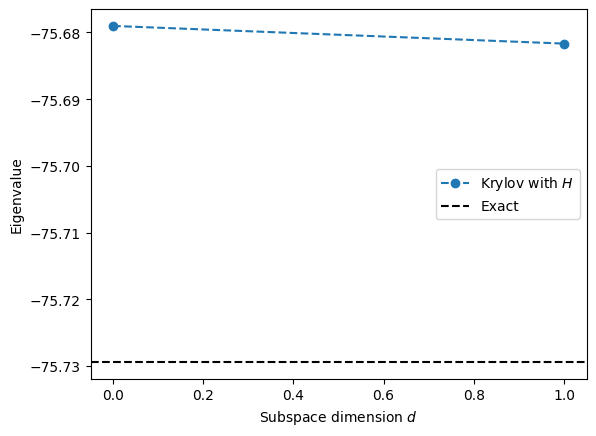

In [68]:
plt.plot(krylov_evals, "--o", label="Krylov with $H$")
plt.axhline(energy_exact, ls="--", color="black", label="Exact")
plt.xlabel("Subspace dimension $d$")
plt.ylabel("Eigenvalue")
plt.legend();

### Unitary Krylov

In [81]:
# See Theorem 3.1 of https://arxiv.org/abs/2110.07492.
dt = np.pi / (evals_exact[-1] - evals_exact[0])
dt

8.011024548856343

In [82]:
vectors_u = []
for k in range(-2 * subspace_dimension, 2 * subspace_dimension + 1, 1):
    print(k)
    Uk = sp.sparse.linalg.expm(-1j * matrix * k * dt)
    vectors_u.append(Uk @ bvec)

-32
-31


KeyboardInterrupt: 

In [ ]:
h, s = fill_h_and_s_matrices(vectors_u, matrix)

In [ ]:
krylov_u_evals = []
for d in range(1, len(h)):
    krylov_energy = solve_regularized_gen_eig(h[:d, :d], s[:d, :d], threshold=threshold)
    print(krylov_energy)
    krylov_u_evals.append(krylov_energy)

In [ ]:
plt.plot(krylov_evals, "--o", label="Krylov with $H$")
plt.plot(krylov_u_evals, "--o", label="Krylov with $U$")
plt.axhline(energy_exact, ls="--", color="black", label="Exact")
plt.xlabel("Subspace dimension $d$")
plt.ylabel("Eigenvalue")
plt.title(f"{nqubits}-qubit Fermi-Hubbard Hamiltonian\nInitial state overlap with ground state = {round(overlap, 3)}")
plt.legend();

## Trotterized unitary Krylov

In [ ]:
import cirq
from cirq.contrib.qasm_import import circuit_from_qasm

import qiskit
import qiskit.qasm2

In [ ]:
def cirq_pauli_sum_to_qiskit_pauli_op(pauli_sum: cirq.PauliSum) -> qiskit.quantum_info.SparsePauliOp:
    """Returns a qiskit.SparsePauliOp representation of the cirq.PauliSum."""
    cirq_pauli_to_str = {cirq.X: "X", cirq.Y: "Y", cirq.Z: "Z"}

    qubits = pauli_sum.qubits
    terms = []
    coeffs = []
    for term in pauli_sum:
        string = ""
        for qubit in qubits:
            if qubit not in term:
                string += "I"
            else:
                string += cirq_pauli_to_str[term[qubit]]
        terms.append(string)
        assert np.isclose(term.coefficient.imag, 0.0, atol=1e-7)
        coeffs.append(term.coefficient.real)
    return qiskit.quantum_info.SparsePauliOp(terms, coeffs)

In [ ]:
hamiltonian_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(hamiltonian_cirq)

In [ ]:
ntrotter_values = [1, 2, 4, 8, 16, 32]
ngates_twoq = []
ngates_oneq = []
depths = []
all_krylov_u_trotter_evals = []

for ntrotter in ntrotter_values:
    print("On ntrotter =", ntrotter)
    trotter_operation = qiskit.circuit.library.PauliEvolutionGate(
        hamiltonian_qiskit,
        time=dt,
        synthesis=qiskit.synthesis.LieTrotter(reps=ntrotter)
    )

    # trotter_circuit = qiskit.QuantumCircuit.from_instructions(
    #     [[trotter_operation]],
    #     qubits=qiskit.QuantumRegister(trotter_operation.num_qubits),
    # )
    trotter_circuit = qiskit.QuantumCircuit(nqubits)
    trotter_circuit.append(trotter_operation, trotter_circuit.qubits)
    trotter_circuit = qiskit.transpile(
        trotter_circuit, basis_gates=["u3", "cx"]
    )  # TODO: Compile to a target backend, e.g. IBM Fez.
    opcounts = trotter_circuit.count_ops()
    ngates_twoq.append(opcounts.get("cx"))
    ngates_oneq.append(opcounts.get("u3"))
    depths.append(trotter_circuit.depth())

    qasm = qiskit.qasm2.dumps(trotter_circuit)
    trotter_circuit_cirq = circuit_from_qasm(qasm.replace("qregless", "q"))

    qubits = sorted(trotter_circuit_cirq.all_qubits())
    Utrotter = cirq.unitary(trotter_circuit_cirq)

    vectors_u_trotter = []
    for k in range(-2 * subspace_dimension, 2 * subspace_dimension + 1, 1):
        # print(k)
        Uk = np.linalg.matrix_power(Utrotter, k)
        vectors_u_trotter.append(Uk @ bvec)
    
    h, s = fill_h_and_s_matrices(vectors_u_trotter, matrix)
    krylov_u_trotter_evals = []
    for d in range(1, len(h)):
        krylov_energy = solve_regularized_gen_eig(h[:d, :d], s[:d, :d], threshold=threshold)
        krylov_u_trotter_evals.append(krylov_energy)
    
    all_krylov_u_trotter_evals.append(krylov_u_trotter_evals)

In [ ]:
kwargs = {"alpha": 0.6667, "mec": "black"}

errors_h = np.abs(np.array(krylov_evals) - energy_exact)
errors_u = np.abs(np.array(krylov_u_evals) - energy_exact)


plt.plot(errors_h, "--s", label="Krylov with $H$", **kwargs)
plt.plot(errors_u, "--s", label="Krylov with $U$", **kwargs)



for ntrotter, krylov_u_trotter_evals in zip(ntrotter_values, all_krylov_u_trotter_evals):
    errors_u_trotter = np.abs(np.array(krylov_u_trotter_evals) - energy_exact)
    plt.plot(errors_u_trotter, "--s", label=rf"Krylov with $U'$ ({ntrotter} Trotter step(s))", **kwargs)

plt.axhline(1e-3, ls="--", color="black", label="Chemical accuracy")

plt.title(f"{nqubits}-qubit Fermi-Hubbard Hamiltonian\nInitial state overlap with ground state = {round(overlap, 3)}")
plt.xlabel("Subspace dimension $d$")
plt.ylabel("Absolute energy error")

plt.yscale("log")
plt.legend(bbox_to_anchor=(1.05, 1));

In [ ]:
plt.plot(ntrotter_values, ngates_oneq, "--o", label="One-qubit gates")
plt.plot(ntrotter_values, ngates_twoq, "--o", label="Two-qubit gates")
plt.plot(ntrotter_values, depths, "--o", label="Circuit depth")

plt.xlabel("Number of Trotter steps")
plt.ylabel("Count")

plt.legend();